# Conductance Calculations for Designing the tweezer trapping chamber

In [1]:
import numpy as np
import scipy.constants as cts
from vacuum_calc import conductance_short_circular_tube,conductance_long_circular_tube
from thermo_kinetic_gas_calc_func import avg_boltzmann_velocity
import pandas as pd
import matplotlib.pyplot as plt

N = cts.value('Avogadro constant') # in particles/mol
kB = cts.value('Boltzmann constant')

# Dominant particles to remove from vacuum
To create a vacuum, air containing many of the following atoms will need to be pumped out. The primary focus will be H2 since its the lightest molecule and therefore traveling the fastest and hardest to pump out. Also, much H2 is trapped in the vacuum components and only really removed once its baked out.

In [2]:
# atomic masses
m_O2 = 16
m_N2 = 14
m_H20 = 18
m_H2 = 2

In [3]:
def convert_atomic_mass_kg(molecular_weight):
    """
    Converts an atomic mass to a mass in kg by converting the atomic weight into SI kg. Molecular weight divided by N
    gets everything in grams, and dividing by 1000 gives it in kg
    :param molecular_weight: periodic table molecular weight
    :return m_kg: mass in kg
    """
    m_kg = (molecular_weight/N)/1000
    return m_kg

## Calculation of avg boltzmann velocity of each of the particles
To calculate the conductance, we need two main parameters:
- average boltzmann velocity
- cross-sectional area and total volume of the particle flow

In [4]:
def avg_boltzmann_velocity(m_atomic,T_C=25):
    """
    :param m_atomic: atomic mass of the given substance
    :param T_C: temperature in celsius, default set to room temperature at 22C
    :return:
    """
    T = T_C + 273.15
    m_kg = convert_atomic_mass_kg(m_atomic)
    v_avg = np.sqrt(8*kB*T/(np.pi*m_kg))
    return v_avg


In [5]:
v_avg_O2 = avg_boltzmann_velocity(m_O2)
v_avg_N2 = avg_boltzmann_velocity(m_N2)
v_avg_H2O = avg_boltzmann_velocity(m_H20)
v_avg_H2 = avg_boltzmann_velocity(m_H2)

# Transmission Probability of round pipes with various aspect ratios
Table 3.1 in page 36 in A User's Guide to Vacuum Technology gives the transmission probability of round pipes of different aspect ratios. So, we import these book results and calculate the aspect ratios of various flanges and their tube lengths in the main chamber to compare to the plot to get a rough estimate of the transmission probability for each of the ports in the main trapping chamber

Each d is a diameter labeled by its corresponding standard flange size in inches. The diameter is the open area that the particles are actually travelling through. 

The l corresponds to the length of the tube in the model we are actually looking at and their calculated aspect ratios below

aspect ratios
1.33" flange: 1.2015625
2.75" tube: 3.925547445255474
4.5" tube: 3.4482758620689653


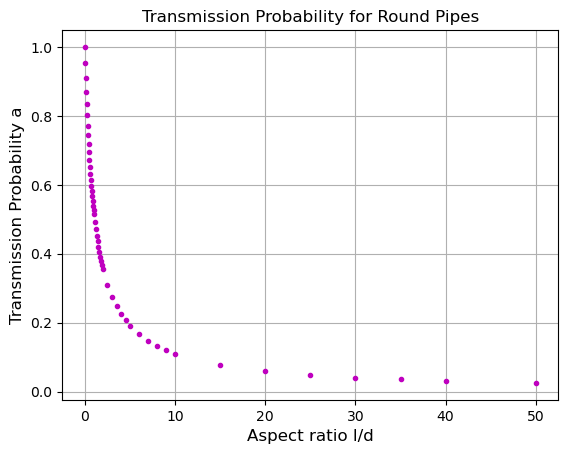

In [6]:
d_275 = 1.370*25.4*(1e-3) # m
l_275 = 5.378*25.4*1e-3

d_450 = 2.9*25.4*(1e-3)
l_450 = 10.*25.4*1e-3  # 6.76*25.4*1e-3

d_133 = 0.640*25.4*(1e-3)
l_133 = 0.769*25.4*(1e-3)

asp_ratio_133 = l_133/d_133
asp_ratio_275 = l_275/d_275
asp_ratio_450 = l_450/d_450

print("aspect ratios")
print("1.33\" flange: "+str(asp_ratio_133))
print("2.75\" tube: "+str(asp_ratio_275))
print("4.5\" tube: "+str(asp_ratio_450))

A_133 = np.pi*(d_133/2)**2
A_275 = np.pi*(d_275/2)**2 # m^2
A_450 = np.pi*(d_450/2)**2

# table 3.1 pg 36 in A User's Guide to Vacuum Technology
TRANS_PROB_DATA_FILE = 'trans_prob_round_pipes.csv'

data = pd.read_csv(TRANS_PROB_DATA_FILE)

LAST_POINTS_RM = 2

all_aspect_ratios = data['l/d']
aspect_ratios = all_aspect_ratios[: len(all_aspect_ratios)-LAST_POINTS_RM]
trans_prob_all = data['a']
trans_prob = trans_prob_all[: len(all_aspect_ratios)-LAST_POINTS_RM]

fig = plt.figure()
plt.ylabel("Transmission Probability a",fontsize=12)
plt.xlabel("Aspect ratio l/d",fontsize=12)
plt.title("Transmission Probability for Round Pipes")
plt.plot(aspect_ratios,trans_prob,'m.')
plt.grid()
plt.show()

Calculate the conductances of each using short tube and long tube formulas

In [7]:
def conductance_short_circular_tube(velocity,cross_sectional_area,a=1):
    """ The conductance for a short circular tube is equivalent to the conductance of an aperature when a=1
    :param velocity: typically avg velocity of the gas, can use rms
    :param A: cross-sectional area that the gas passes through
    :param a: transmission probability through the tube
    :return C: conductance of the system in L/s"""
    conductance = a*(velocity*cross_sectional_area)/4
    return conductance*1000

def conductance_long_circular_tube(velocity,diameter,length):
    """
    Conductance of a long circular rounded tube calcuations
    :param velocity: avg boltzmann velocity of a particle
    :param diameter: diameter of the pipe
    :param l: length of the pipe
    :return: C_tube is conductance of the tube in L/s (multiply by 1000 for L)
    """
    c_tube = np.pi*velocity*diameter**3/(12*length)
    return c_tube*1000

In [8]:
C_H2_133 = conductance_short_circular_tube(v_avg_H2,A_133)
C_H2_275 = conductance_short_circular_tube(v_avg_H2,A_275)
C_H2_450 = conductance_short_circular_tube(v_avg_H2,A_450)

C_H2_long_133 = conductance_long_circular_tube(v_avg_H2,d_133,l_133)
C_H2_long_275 = conductance_long_circular_tube(v_avg_H2,d_275,l_275)
C_H2_long_450 = conductance_long_circular_tube(v_avg_H2,d_450,l_450)

print("Aperture conductance")
print("H2 (L/s), 1.33: "+str(C_H2_133))
print("H2 (L/s), 2.75: "+str(C_H2_275))
print("H2 (L/s), 4.5: "+str(C_H2_450))

print("Tube conductance")
print("H2 (L/s), 1.33: "+str(C_H2_long_133))
print("H2 (L/s), 2.75: "+str(C_H2_long_275))
print("H2 (L/s), 4.5: "+str(C_H2_long_450))

Aperture conductance
H2 (L/s), 1.33: 92.18214932294887
H2 (L/s), 2.75: 422.40399429746776
H2 (L/s), 4.5: 1892.7047749169928
Tube conductance
H2 (L/s), 1.33: 102.29141840778027
H2 (L/s), 2.75: 143.4717917906361
H2 (L/s), 4.5: 731.8458463012372


In [9]:
731*.3

219.29999999999998

# Conductances of Differential pumping tube (DPT)
Conductance of the DPT for further DPT analysis.


## Conductance of the DPT using the calculated a
Since our dominant source of background gas is H2 and is the lightest atom anyways, it will need the highest amount of pumping rate to get it out. We will only deal with conductances of H2

In [11]:
d_DPT = 0.236*25.4*(1e-3) # m
l_DPT = 4.315*25.4*(1e-3) # m
asp_ratio_DPT = l_DPT/d_DPT
a_DPT = 0.061

area_DPT = np.pi*(d_DPT/2)**2
cdt_DPT_apt = conductance_short_circular_tube(v_avg_H2,area_DPT)
cdt_DPT_apt_a = conductance_short_circular_tube(v_avg_H2,area_DPT,a=0.061)
cdt_DPT_long = conductance_long_circular_tube(v_avg_H2,d_DPT,l_DPT)
print("Conductance using dimensions of the DPT ")
print("----------------------------------------")
print("Conductance at the aperature: "+str(cdt_DPT_apt))
print("Conductance using the value of a and short tube: "+str(cdt_DPT_apt_a))
print("Conductance using long tube: "+str(cdt_DPT_long))

Conductance using dimensions of the DPT 
----------------------------------------
Conductance at the aperature: 12.53461178879629
Conductance using the value of a and short tube: 0.7646113191165737
Conductance using long tube: 0.9140728874950711


## Use the set conductance and fixed pressure to solve for pumping rate
Find the flow rate of atoms from the high pressure oven part before going through the DPT and into the main chamber


The conductance through the tube is a set value based only on the geometry of the differential pumping tube. I used this as my fixed rate to calculate the throughput, Q, as the fixed quantity we are after. This is the number of molecules coming in through the tube per time.

$$
Q = \frac{P_{0} V}{s}
$$

conductance is a geometric quantity so I use the conductance of the DPT to give us the liters/second unit and multiply by the fixed pressure. The transmission probability table tells us the percent of the molecules which actually make it through the tube.

We can replace $P_0 V$ with $N_{out}$, the number of particles actually coming through by making a substitution with the ideal gas law.

$$
P V = N k_b T
$$

the temperature is not changing, and $k_b$ is just the boltzmann constant, so both of these are constants.

unsure if the constant T and k_b does actually cancel out???


In [12]:
high_pressure = (7.3e-8)*(101325/760) # high pressure in pascals
low_pressure = (1e-11)*(101325/760)  # low pressure in pascals


Solve for L', pumping rate

$$
(L/s)' = a (L/s) \frac{P_{HP}}{P_{LP}}
$$

In [17]:
pump_rate_1 = a_DPT*cdt_DPT_apt*(high_pressure/low_pressure)
pump_rate_2 = a_DPT*cdt_DPT_apt_a*(high_pressure/low_pressure)
pump_rate_3 = a_DPT*cdt_DPT_long*(high_pressure/low_pressure)

In [16]:
print("Pump rate 1: "+str(pump_rate_1))
print("Pump rate 2: "+str(pump_rate_2))
print("Pump rate 3: "+str(pump_rate_3))

a*C_ap 558.1662629550988
Pump rate 2: 558.1662629550988
Pump rate 3: 40.70366568015552
